In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')


import acquire

from datetime import timedelta, datetime
from sklearn.model_selection import TimeSeriesSplit

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

In [2]:
# ACQUIRE DATA

data = acquire.get_coffee()
data.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,1/1/23,7:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,1/1/23,7:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,1/1/23,7:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,1/1/23,7:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,1/1/23,7:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


In [3]:
# PREPARE DATA

# Set index
data = acquire.set_index(data)
data.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
transaction_date_time,,,,,,,,,,,
2023-01-01 07:06:11,1,1/1/23,7:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
2023-01-01 07:08:56,2,1/1/23,7:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2023-01-01 07:14:04,3,1/1/23,7:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
2023-01-01 07:20:24,4,1/1/23,7:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
2023-01-01 07:22:41,5,1/1/23,7:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


In [4]:
# Add and delete columns, remove outliers

data = acquire.prep_coffee(data)
data

,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,transaction_total,month,day,hour
transaction_date_time,,,,,,,,,,,,
2023-01-01 07:06:11,2,5,Lower Manhattan,32,3.00,Coffee,Gourmet brewed coffee,Ethiopia Rg,6.00,January,Sunday,7
2023-01-01 07:08:56,2,5,Lower Manhattan,57,3.10,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6.20,January,Sunday,7
2023-01-01 07:14:04,2,5,Lower Manhattan,59,4.50,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,9.00,January,Sunday,7
2023-01-01 07:20:24,1,5,Lower Manhattan,22,2.00,Coffee,Drip coffee,Our Old Time Diner Blend Sm,2.00,January,Sunday,7
2023-01-01 07:22:41,2,5,Lower Manhattan,57,3.10,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6.20,January,Sunday,7
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30 20:18:41,2,8,Hell's Kitchen,44,2.50,Tea,Brewed herbal tea,Peppermint Rg,5.00,June,Friday,20
2023-06-30 20:25:10,2,8,Hell's Kitchen,49,3.00,Tea,Brewed Black tea,English Breakfast Lg,6.00,June,Friday,20
2023-06-30 20:31:34,1,8,Hell's Kitchen,45,3.00,Tea,Brewed herbal tea,Peppermint Lg,3.00,June,Friday,20


In [5]:
data.shape

(148104, 12)

In [6]:
# Split data

In [7]:
train_size = .70
n = data.shape[0]
test_start_index = round(train_size * n)

In [8]:
train = data[:test_start_index] # everything up (not including) to the test_start_index
test = data[test_start_index:] # everything from the test_start_index to the end
train.shape, test.shape

((103673, 12), (44431, 12))

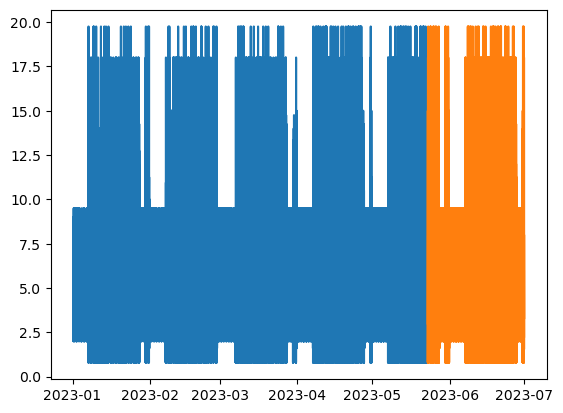

In [9]:
plt.plot(train.index, train.transaction_total)
plt.plot(test.index, test.transaction_total)

In [10]:
# Define and plot target variable

<Axes: ylabel='Frequency'>

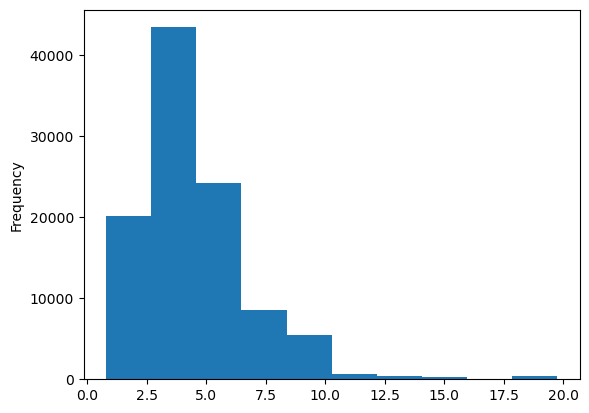

In [11]:
y = train.transaction_total
y.plot.hist()

In [12]:
train.transaction_total.max()

19.75

In [13]:
train.transaction_total.median()

3.75

In [14]:
train.transaction_total.mean()

4.496145862471424

In [15]:
# EXPLORE DATA

In [16]:
# Exploratory Questions:
    # -- Does time, day or month have an impact on transaction_total?
    # -- Is there a relationship between product_category or product_type and transaction_total?
    # -- Does store_location matter?

In [17]:
# Resample Data -- Daily

In [18]:
# create dataframe with summed observations, resampled daily

by_day = train.resample('D').sum()
by_day.head()

,transaction_qty,store_id,product_id,unit_price,transaction_total,hour
transaction_date_time,,,,,,
2023-01-01,802,2922,25406,1731.80,2508.20,7479
2023-01-02,790,2991,26332,1743.95,2403.35,7746
2023-01-03,823,3133,27579,1826.60,2565.00,8033
2023-01-04,726,2621,22629,1533.40,2220.10,6890
2023-01-05,778,2843,25757,1715.35,2418.85,7379


<Axes: xlabel='transaction_date_time'>

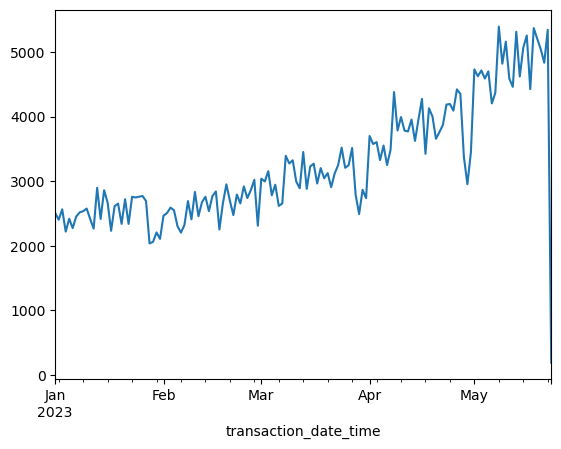

In [19]:
# plot resampled target variable that has been resampled and summed

by_day.transaction_total.plot()

In [20]:
# Resample Data -- Weekly

In [21]:
# create dataframe with summed observations, resampled weekly

by_week = train.resample('W').sum()
by_week.head()

,transaction_qty,store_id,product_id,unit_price,transaction_total,hour
transaction_date_time,,,,,,
2023-01-01,802,2922,25406,1731.80,2508.20,7479
2023-01-08,5445,20472,178197,11989.43,16851.48,49779
2023-01-15,5741,22211,198359,13242.68,17970.53,44219
2023-01-22,5645,20940,195520,12798.91,17569.31,43376
2023-01-29,5754,20108,183201,12165.63,17830.28,45899


<Axes: xlabel='transaction_date_time'>

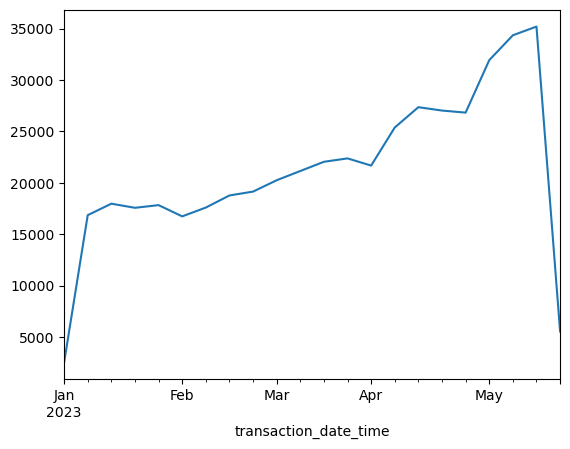

In [22]:
# plot resampled target variable that has been resampled and summed

by_week.transaction_total.plot()

In [24]:
# Construct lag plots of the resampled data to see if the target variable follows a linear pattern.

In [25]:
# Lag Plot -- By Week

In [26]:
y = by_week.transaction_total

[Text(0.5, 0, 't'), Text(0, 0.5, 't+1')]

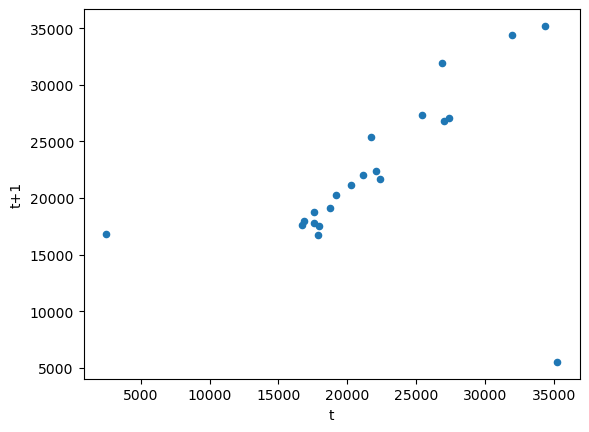

In [27]:
by_week['y(t + 1)'] = by_week.transaction_total.shift(-1)
ax = by_week.plot.scatter(x='transaction_total', y='y(t + 1)')
ax.set(xlabel='t', ylabel='t+1')

In [28]:
by_week['next_week'] = by_week.transaction_total.shift(-1)
by_week.head()

,transaction_qty,store_id,product_id,unit_price,transaction_total,hour,y(t + 1),next_week
transaction_date_time,,,,,,,,
2023-01-01,802,2922,25406,1731.80,2508.20,7479,16851.48,16851.48
2023-01-08,5445,20472,178197,11989.43,16851.48,49779,17970.53,17970.53
2023-01-15,5741,22211,198359,13242.68,17970.53,44219,17569.31,17569.31
2023-01-22,5645,20940,195520,12798.91,17569.31,43376,17830.28,17830.28
2023-01-29,5754,20108,183201,12165.63,17830.28,45899,16734.74,16734.74


In [29]:
# Lag Plot -- By Day

In [30]:
y2 = by_day.transaction_total

[Text(0.5, 0, 't'), Text(0, 0.5, 't+1')]

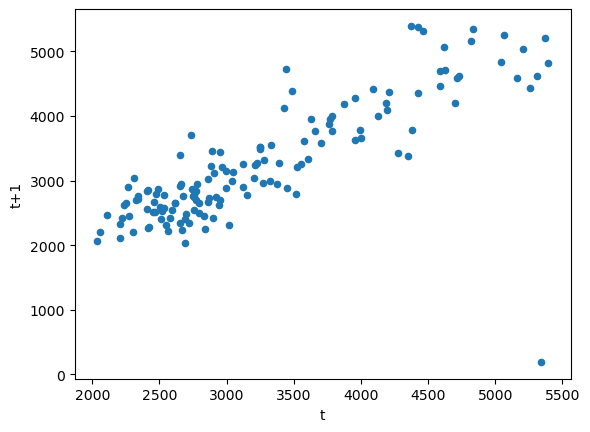

In [31]:
by_day['y2(t + 1)'] = by_day.transaction_total.shift(-1)
ax = by_day.plot.scatter(x='transaction_total', y='y2(t + 1)')
ax.set(xlabel='t', ylabel='t+1')

In [32]:
by_day['tomorrow'] = by_day.transaction_total.shift(-1)
by_day.head()

,transaction_qty,store_id,product_id,unit_price,transaction_total,hour,y2(t + 1),tomorrow
transaction_date_time,,,,,,,,
2023-01-01,802,2922,25406,1731.80,2508.20,7479,2403.35,2403.35
2023-01-02,790,2991,26332,1743.95,2403.35,7746,2565.00,2565.00
2023-01-03,823,3133,27579,1826.60,2565.00,8033,2220.10,2220.10
2023-01-04,726,2621,22629,1533.40,2220.10,6890,2418.85,2418.85
2023-01-05,778,2843,25757,1715.35,2418.85,7379,2273.85,2273.85


In [33]:
# MODELING

In [34]:
# evaluation function to compute rmse
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = sqrt(mean_squared_error(target_var, yhat_df))
    return rmse

In [35]:
# plot and evaluate 
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(by_week['transaction_total'], label = 'By Week', linewidth = 1)
    plt.plot(yhat_df['transaction_total'])
    plt.title('transaction_total')
    # rmse = by_week('transaction_total')
    rmse = sqrt(mean_squared_error(by_week[target_var], yhat_df))
    print('transaction_total', '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [36]:
# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return pd.concat([eval_df, d])

In [37]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [38]:
# MODEL 1 -- Last Observed Value (Weekly)

In [39]:
last_sales = by_week['transaction_total'][-1:][0]

yhat_df = pd.DataFrame(
    {'transaction_total': [last_sales]},
    index=by_week.index)

yhat_df.head()

,transaction_total
transaction_date_time,
2023-01-01,5535.66
2023-01-08,5535.66
2023-01-15,5535.66
2023-01-22,5535.66
2023-01-29,5535.66


In [40]:
target_var = by_week['transaction_total']
evaluate(target_var)

17438.73205606117

In [41]:
eval_df = append_eval_df(model_type = 'last_observed_value_weekly', 
                             target_var = by_week['transaction_total'])
eval_df

,model_type,target_var,rmse
0,last_observed_value_weekly,transaction_date_time 2023-01-01 2508.20 2...,17438.732056


In [42]:
# MODEL 2 -- Last Observed Value (Daily)

In [43]:
last_sales_2 = by_day['transaction_total'][-1:][0]

yhat_df = pd.DataFrame(
    {'transaction_total': [last_sales_2]},
    index=by_day.index)

yhat_df.head()

,transaction_total
transaction_date_time,
2023-01-01,191.95
2023-01-02,191.95
2023-01-03,191.95
2023-01-04,191.95
2023-01-05,191.95


In [44]:
target_var = by_day['transaction_total']
rmse = sqrt(mean_squared_error(target_var, yhat_df))
rmse

3198.641744137199

In [45]:
eval_df = append_eval_df(model_type = 'last_observed_value_daily', 
                             target_var = by_day['transaction_total'])
eval_df

,model_type,target_var,rmse
0,last_observed_value_weekly,transaction_date_time 2023-01-01 2508.20 2...,17438.732056
0,last_observed_value_daily,transaction_date_time 2023-01-01 2508.20 20...,3198.641744


In [46]:
# MODEL 3 -- Holt's Linear Trend (Weekly)

In [47]:
last_sales = by_week['transaction_total'][-1:][0]

yhat_df = pd.DataFrame(
    {'transaction_total': [last_sales]},
    index=by_week.index)

In [48]:
model = Holt(by_week['transaction_total'], exponential=False, damped=True)
model = model.fit(optimized=True)
yhat_values = model.predict(start = by_week.index[0],     #Should I be using my test dataset here?
                            end = by_week.index[-1])
yhat_df['transaction_total'] = round(yhat_values, 2)

yhat_df.head()

,transaction_total
transaction_date_time,
2023-01-01,16708.05
2023-01-08,10785.49
2023-01-15,25125.54
2023-01-22,24270.05
2023-01-29,19873.87


In [49]:
target_var2 = by_week['transaction_total']
evaluate(target_var2)

8006.299321487141

In [50]:
eval_df = append_eval_df(model_type = 'holts_weekly', 
                             target_var = by_week['transaction_total'])
eval_df

,model_type,target_var,rmse
0,last_observed_value_weekly,transaction_date_time 2023-01-01 2508.20 2...,17438.732056
0,last_observed_value_daily,transaction_date_time 2023-01-01 2508.20 20...,3198.641744
0,holts_weekly,transaction_date_time 2023-01-01 2508.20 2...,8006.299321


In [51]:
# MODEL 4 -- Holt's Linear Trend (Daily)

In [52]:
last_sales_2 = by_day['transaction_total'][-1:][0]

yhat_df = pd.DataFrame(
    {'transaction_total': [last_sales_2]},
    index=by_day.index)

In [53]:
model = Holt(by_day['transaction_total'], exponential=False, damped=True)
model = model.fit(optimized=True)
yhat_values = model.predict(start = by_week.index[0],     #Should I be using my test dataset here?
                            end = by_week.index[-1])
yhat_df['transaction_total'] = round(yhat_values, 2)

yhat_df.head()

,transaction_total
transaction_date_time,
2023-01-01,2404.40
2023-01-02,2338.33
2023-01-03,2261.48
2023-01-04,2271.14
2023-01-05,2161.99


In [54]:
target_var4 = by_day['transaction_total']
evaluate(target_var4)

541.4244188760282

In [55]:
eval_df = append_eval_df(model_type = 'holts_daily', 
                             target_var = by_day['transaction_total'])
eval_df

,model_type,target_var,rmse
0,last_observed_value_weekly,transaction_date_time 2023-01-01 2508.20 2...,17438.732056
0,last_observed_value_daily,transaction_date_time 2023-01-01 2508.20 20...,3198.641744
0,holts_weekly,transaction_date_time 2023-01-01 2508.20 2...,8006.299321
0,holts_daily,transaction_date_time 2023-01-01 2508.20 20...,541.424419


transaction_total -- RMSE: 541


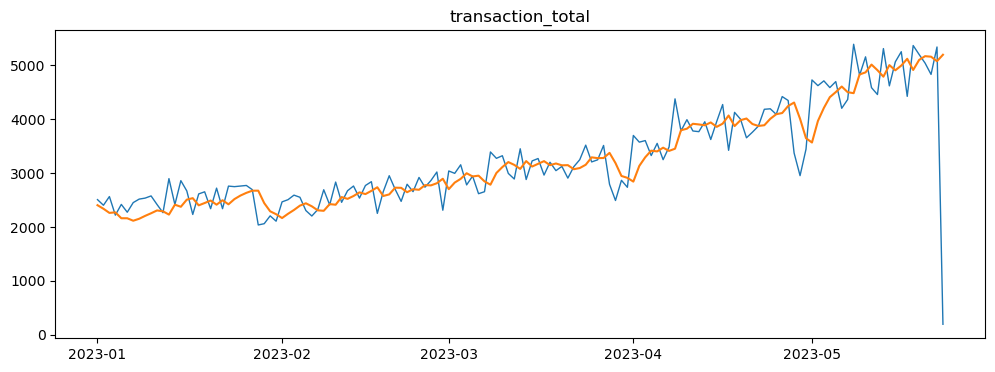

In [56]:
# Plot Actual vs. Predicted Values

plt.figure(figsize = (12,4))
plt.plot(by_day['transaction_total'], label = 'By Day', linewidth = 1)
plt.plot(yhat_df['transaction_total'])
plt.title('transaction_total')
# rmse = by_week('transaction_total')
rmse = sqrt(mean_squared_error(by_day['transaction_total'], yhat_df))
print('transaction_total', '-- RMSE: {:.0f}'.format(rmse))
plt.show()

In [57]:
# CONCLUSION: MODEL 4 -- Holt's Linear Trend (Daily) is the best predictor of average transaction_total.